# RGI09 (Russian Arctic)

F. Maussion & S. Galos

Same outlines as in RGI6, with a small correction of ice divides

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import (mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, 
                   find_duplicates, open_zip_shapefile, correct_geoms, fix_overaps)
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 9

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '09_rgi60_RussianArctic.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

N        A               analysts  submitters  release_date  \
subm_id                                                                   
567      1069  51591.5                Moholdt      Koenig          2013   
671      1474  22390.1                   Paul        Paul          2017   
694      1510  12370.7  Paul, Rastner, Schaub        Paul          2018   
759         3    841.8             Kochtitzky  Kochtitzky          2021   
788       730  22216.5             Lavrentiev  Lavrentiev          2020   
789       226  16785.9                Smirnov    Khromova          2020   

                                                 geog_area  src_date_mode  \
subm_id                                                                     
567                        Svalbard, Jan Mayen, and Bouvet           2002   
671                                  Various (GlobGlacier)           2016   
694                                  Various (GlobGlacier)           2016   
759                                         Coropuna, Peru           2000   
788                                     Siberian Mountains           2019   
789      Russian Glaciers (exact boundaries of RC to be...           2020   

         src_date_min  src_date_max  
subm_id                              
567              2000          2010  
671              2013          2016  
694              2016          2016  
759              2000          2000  
788              2019          2019  
789              2019          2020

In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [6]:
# For this region RGI07 shall be equal to RGI06 so...
#...extract RGI06 from GLIMS by 'subm_id' 567 which refers to data by Moholdt et al. 2012
s_567 = shp.loc[shp['subm_id']== 567].copy()
s_567['is_rgi6'] = True

In [7]:
s_759 = shp.loc[shp['subm_id']== 759].copy()
s_759['is_rgi6'] = False

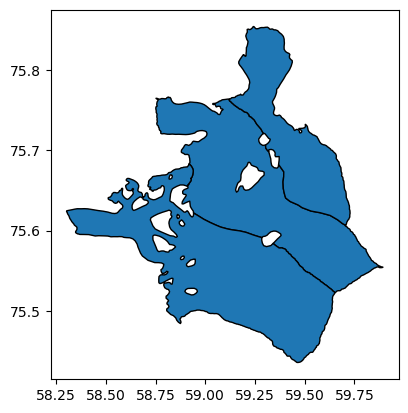

In [8]:
s_759.plot(edgecolor='k');

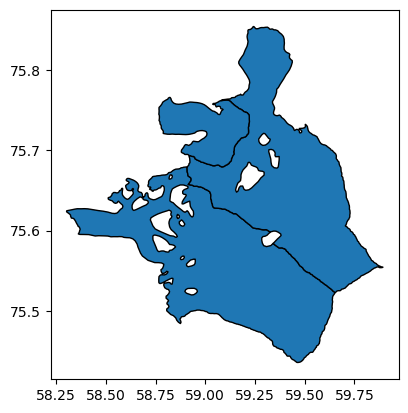

In [9]:
# Remove the three ids that need to be replaced in GLIMS
to_replace = ['G059108E75722N', 'G059314E75523N', 'G059401E75657N']
sel = s_567.loc[s_567['glac_id'].isin(to_replace)]
sel.plot(edgecolor='k');

There is some area difference but it's ok it's Will: 

In [10]:
area_diff = (s_759['area'].sum() - sel['area'].sum())
area_diff

3500380.3191224337

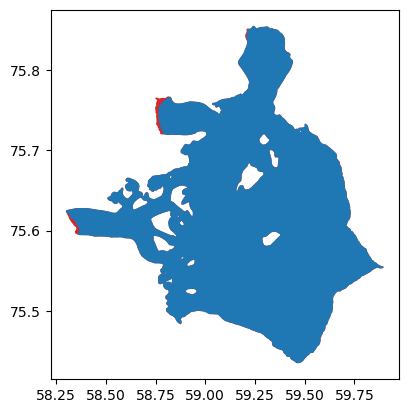

In [11]:
ax = s_759.plot(color='C3', edgecolor='C3');
ax = sel.plot(ax=ax, edgecolor='C0');

In [12]:
s_567 = s_567.loc[~ s_567['glac_id'].isin(to_replace)].copy()

In [13]:
s_567.geog_area.iloc[0]

'Svalbard, Jan Mayen, and Bouvet'

In [14]:
s_759['geog_area'] = s_567.geog_area.iloc[0]

In [15]:
rgi7 = pd.concat([s_567, s_759])

### Some sanity checks 

In [16]:
rgi7 = correct_geoms(rgi7)

Found 1 invalid geometries out of 1069.
After correction, 0 geometries are still invalid.
Area changed by -0.3 m2 (-0.0000%, or 0 tiny glaciers)


In [17]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [18]:
rgi7 = fix_overaps(rgi7)

Finding intersecting geometries
Computing overlap of intersecting pairs
Found 2 overlaps out of 1069. Correcting...
After correction, Area changed by -6.8 m2 (-0.0000%, or 0 tiny glaciers)
Final check...
Finding intersecting geometries
Computing overlap of intersecting pairs
OK! Check done


In [19]:
rgi7 = correct_geoms(rgi7)

Found 0 invalid geometries out of 1069.


In [20]:
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

1069
1069


In [21]:
sdf, df_class = submission_summary(rgi7)
df_class

N  N NA
subm_id            
567      1066  1066
759         3     3

In [22]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

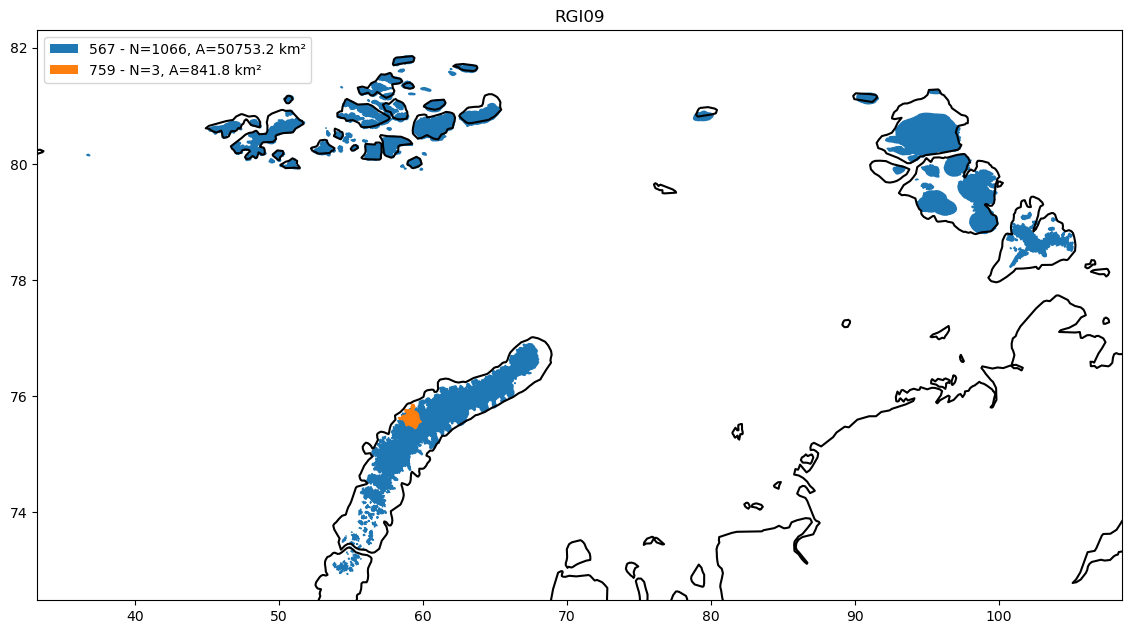

In [23]:
plot_map(rgi7, reg, loc='upper left')

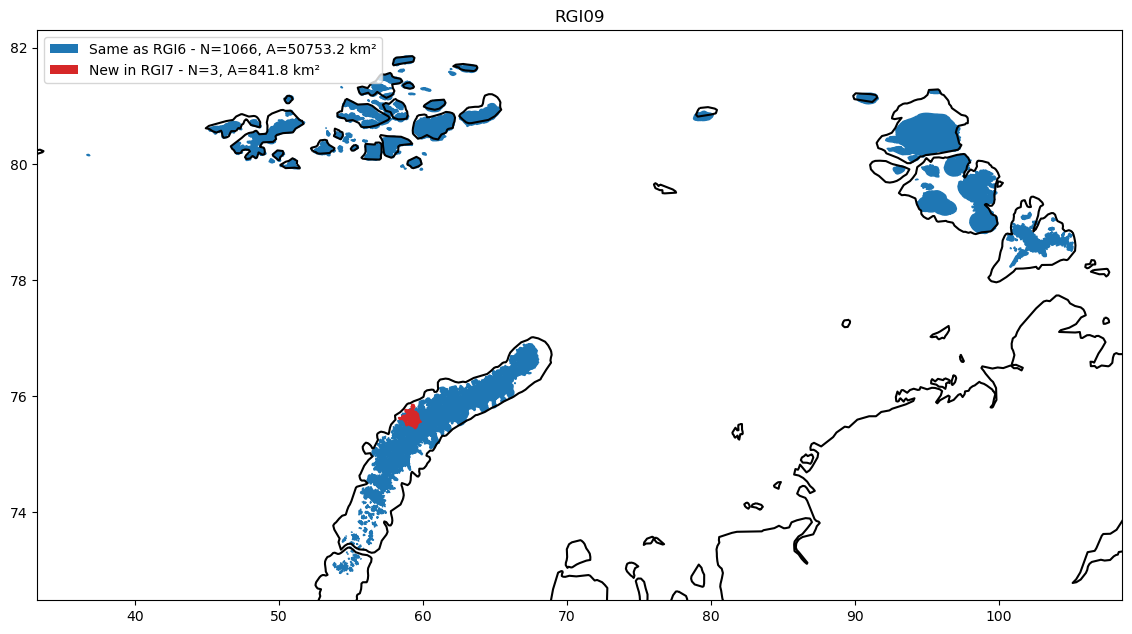

In [24]:
plot_map(rgi7, reg, loc='upper left', is_rgi6=True)

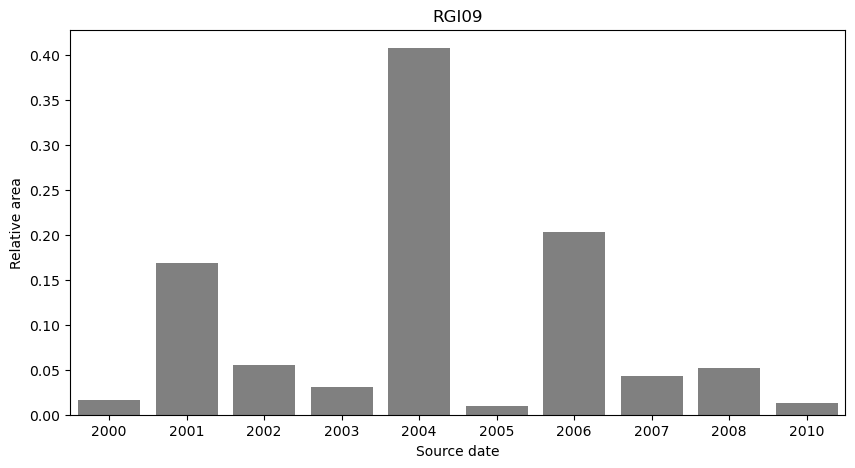

In [25]:
plot_date_hist(rgi7, reg)

### Text for github

In [26]:
fgh = sdf.T
fgh

subm_id                                    567  \
N                                         1066   
A                                      50753.2   
analysts                               Moholdt   
submitters                              Koenig   
release_date                              2013   
geog_area      Svalbard, Jan Mayen, and Bouvet   
src_date_mode                             2002   
src_date_min                              2000   
src_date_max                              2010   

subm_id                                    759  
N                                            3  
A                                        841.8  
analysts                            Kochtitzky  
submitters                          Kochtitzky  
release_date                              2021  
geog_area      Svalbard, Jan Mayen, and Bouvet  
src_date_mode                             2000  
src_date_min                              2000  
src_date_max                              2000

In [27]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 567                             | 759                             |
|:--------------|:--------------------------------|:--------------------------------|
| N             | 1066                            | 3                               |
| A             | 50753.2                         | 841.8                           |
| analysts      | Moholdt                         | Kochtitzky                      |
| submitters    | Koenig                          | Kochtitzky                      |
| release_date  | 2013                            | 2021                            |
| geog_area     | Svalbard, Jan Mayen, and Bouvet | Svalbard, Jan Mayen, and Bouvet |
| src_date_mode | 2002                            | 2000                            |
| src_date_min  | 2000                            | 2000                            |
| src_date_max  | 2010                            | 2000                            |


## Write out and tar 

In [28]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI09/
RGI09/RGI09.prj
RGI09/RGI09.cpg
RGI09/RGI09.shx
RGI09/RGI09.shp
RGI09/RGI09.dbf
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI09.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI09'], returncode=0)


## Consistency check with RGI6 

In [ ]:
# load reference data
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [ ]:
len(rgi7), len(rgi6)

Test the areas:

In [ ]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [ ]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() + area_diff - rgi7['area'].sum()) * 1e-6)

The number of individual gaciers is the same! The total areas differ by only 777 m²...what else do we want?!